In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, ttest_ind

# Load dataset 

df = pd.read_csv("monthly_leads_and_responses.csv")

# Ensure groups and sorting are correct
df = df.sort_values(["day", "group"])

print(df)

     day    group  cumulative_responses  monthly_leads  response_rate
0      1  control                     6           1000          0.006
1      1     test                     7           1000          0.007
2      2  control                    10           1000          0.010
3      2     test                    15           1000          0.015
4      3  control                    15           1000          0.015
..   ...      ...                   ...            ...            ...
109   55     test                   363           1000          0.363
110   56  control                   348           1000          0.348
111   56     test                   366           1000          0.366
112   57  control                   369           1000          0.369
113   57     test                   368           1000          0.368

[114 rows x 5 columns]


In [2]:
# Prepare cumulative data for test vs control
pivot = df.pivot(index="day", columns="group", values="response_rate")

# Interim index
pivot["n"] = np.arange(1, len(pivot) + 1)

# Difference in cumulative response rates (test - control)
pivot["diff"] = pivot["test"] - pivot["control"]

In [3]:
# Find the Z-score & p-values per interim

# Standard error approximation for response rate differences
pivot["se"] = np.sqrt(
    pivot["test"] * (1 - pivot["test"]) +
    pivot["control"] * (1 - pivot["control"])
).replace(0, 1e-9)

# Z-scores
pivot["z_score"] = pivot["diff"] / pivot["se"]

# O'Brien-Fleming boundary
alpha = 0.05
pivot["obf_boundary"] = norm.ppf(1 - alpha / (2 * np.sqrt(pivot["n"])))

In [4]:
# Bayesian Posterior updating

tau2 = 1.0

post_means = []
post_sds = []
post_probs = []

for i in range(len(pivot)):
    n = pivot["n"].iloc[i]
    mean_diff = pivot["diff"].iloc[i]
    sigma2 = pivot["se"].iloc[i] ** 2
    
    post_var = 1 / (n / sigma2 + 1 / tau2)
    post_mean = post_var * (n * mean_diff / sigma2)
    post_sd = np.sqrt(post_var)

    post_prob = 1 - norm.cdf(0, loc=post_mean, scale=post_sd)
    
    post_means.append(post_mean)
    post_sds.append(post_sd)
    post_probs.append(post_prob)

pivot["posterior_mean"] = post_means
pivot["posterior_sd"] = post_sds
pivot["post_prob_effect_gt_0"] = post_probs

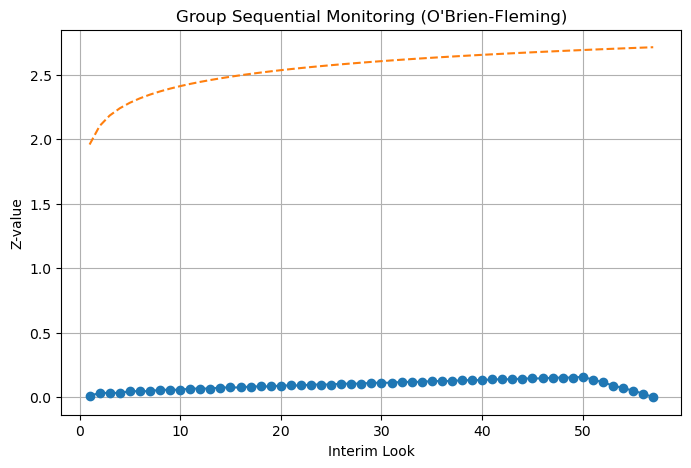

In [5]:
# Plot Group Sequential Monitoring

plt.figure(figsize=(8,5))
plt.plot(pivot["n"], pivot["z_score"], marker="o")
plt.plot(pivot["n"], pivot["obf_boundary"], linestyle="--")
plt.xlabel("Interim Look")
plt.ylabel("Z-value")
plt.title("Group Sequential Monitoring (O'Brien-Fleming)")
plt.grid(True)
plt.show()

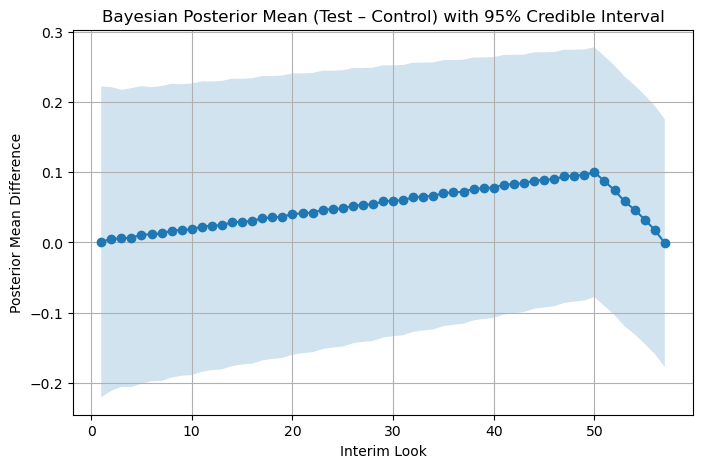

In [6]:
# Plot Bayesian Posterior Mean & CI

plt.figure(figsize=(8,5))
plt.plot(pivot["n"], pivot["posterior_mean"], marker="o")
lower = pivot["posterior_mean"] - 1.96 * pivot["posterior_sd"]
upper = pivot["posterior_mean"] + 1.96 * pivot["posterior_sd"]
plt.fill_between(pivot["n"], lower, upper, alpha=0.2)
plt.xlabel("Interim Look")
plt.ylabel("Posterior Mean Difference")
plt.title("Bayesian Posterior Mean (Test – Control) with 95% Credible Interval")
plt.grid(True)
plt.show()

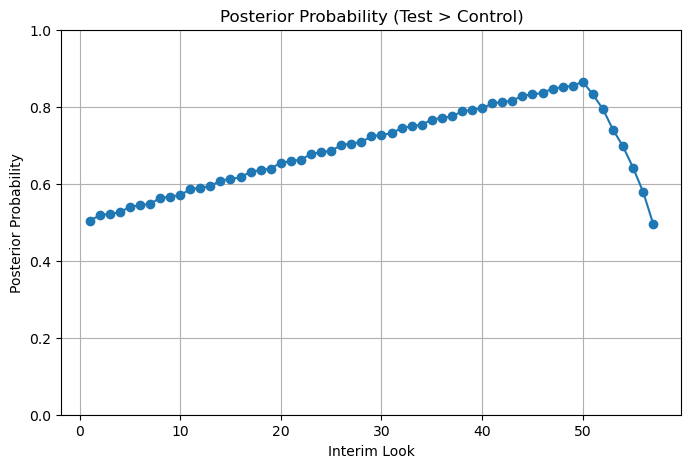

In [7]:
# Plot Posterior Probability

plt.figure(figsize=(8,5))
plt.plot(pivot["n"], pivot["post_prob_effect_gt_0"], marker="o")
plt.xlabel("Interim Look")
plt.ylabel("Posterior Probability")
plt.title("Posterior Probability (Test > Control)")
plt.ylim(0, 1)
plt.grid(True)
plt.show()